## Description:

- Calculates sun's position on panoramic
- Determines visible sky
- Calculates sun glare

In [15]:
import matplotlib.pyplot as plt
from pysolar.solar import get_altitude, get_azimuth
from datetime import datetime, timezone
from PIL import Image
import math

def plot_dot_on_image(img_path, xc, yc):

    with Image.open(img_path) as img:
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.scatter(xc, yc, color='red', label="Sun's Incidence Point")
        plt.text(xc + 10, yc - 10, f"({int(xc)}, {int(yc)})", color='red', fontsize=12)
        plt.title("Sun's Incidence Point on Cylindrical GSV Panorama")
        plt.show()

def get_image_width_height(img_path):
    with Image.open(img_path) as img:
        width, height = img.size
    return width, height

def get_sun_position_east(latitude: float, longitude: float, date: datetime):
    altitude = get_altitude(latitude, longitude, date)  # degrees
    azimuth = get_azimuth(latitude, longitude, date)  #  degrees

    # convert to be anticlockwise from east
    azimuth = 90 - azimuth
    if azimuth < 0:
        azimuth = azimuth + 360  

    return altitude, azimuth


def get_sun_position_on_panoramic_with_heading_date_slope(pan_img_path, lat, long, heading, date=datetime.now(timezone.utc), driveway_slope=0):
    driving_direction = heading
    
    altitude, azimuth = get_sun_position_east(lat, long, date)
    
    wc, hc = get_image_width_height(pan_img_path)
    cx = wc/2
    cy = hc/2

    rad_azimuth = math.radians(azimuth)
    rad_altitude = math.radians(altitude)
    rad_driving_direction = math.radians(driving_direction)
    rad_driveway_slope = math.radians(driveway_slope)

    sun_x = (((rad_driving_direction - rad_azimuth) / (2 * math.pi)) * wc) + cx
    sun_y = cy - (((rad_altitude - rad_driveway_slope) / (math.pi/2)) * hc)
    
    return sun_x, sun_y

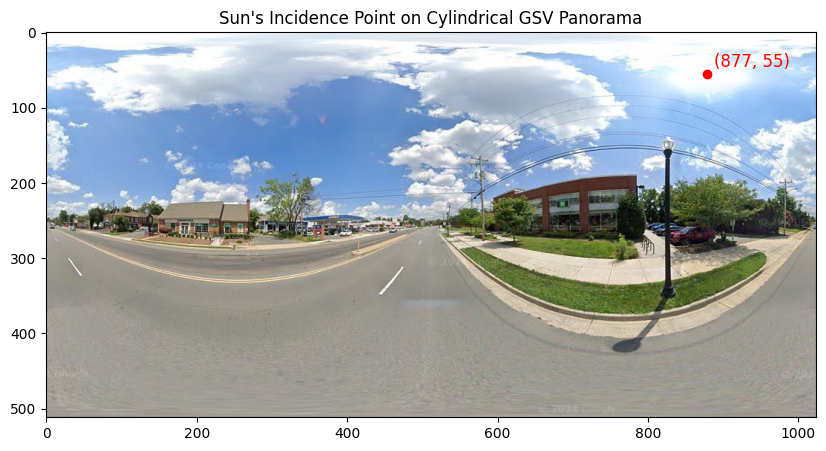

In [16]:
from datetime import datetime, timedelta, timezone


def determine_sun_position(panoramic_path, lat, long, date, heading, tilt):

    # calculate the sun position for the given time
    xc, yc = get_sun_position_on_panoramic_with_heading_date_slope(panoramic_path, lat, long, heading, date=date, driveway_slope=tilt)

    wc, hc = get_image_width_height(panoramic_path)
    
    # wrap the x-coordinate around the panoramic width
    xc = xc % wc

    #plot it 
    plot_dot_on_image(panoramic_path, xc, yc)

    return xc, yc





def main():
    # note the date is in UTC
    date = datetime(2024, 10, 25, 18, 0, 0, tzinfo=timezone.utc)
    
    # Note: we get this from api metadata calls (but just hardcoded for now)
    lat, long = (38.8959185,-77.139306)
    heading = 18.015519999999995 # Note: anticlockwise from east
    tilt = 1.0010999999999939
  
    determine_sun_position("data\panoramic_imgs\IqwvIQfrbsnwcjSrtfNDCA.jpg", lat, long, date, heading, tilt)
    


main()  